In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv
/kaggle/input/machine-failure-predictions/machine failure.csv


In [2]:
import math
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from scipy.stats.mstats import winsorize
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
from xgboost import XGBClassifier
from catboost import CatBoostRegressor as cbr
from lightgbm import LGBMRegressor as lgbmr
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e17/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e17/test.csv')
sample_sub = pd.read_csv('/kaggle/input/playground-series-s3e17/sample_submission.csv')

In [4]:
train.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [5]:
train.columns = train.columns.str.replace('[\[\]]', '', regex=True)

In [6]:
# def summary(df):
#     print(f'data shape: {df.shape}')  
#     summ = pd.DataFrame(df.dtypes, columns=['data type'])
#     summ['missing'] = df.isnull().sum().values 
#     summ['missing'] = df.isnull().sum().values / len(df)* 100
#     summ['unique'] = df.nunique().values
#     desc = pd.DataFrame(df.describe(include='all').transpose())
#     summ['min'] = desc['min'].values
#     summ['max'] = desc['max'].values
#     return summ
# summary(train)

In [7]:
# class_counts = train['Machine failure'].value_counts()

# colors = ['#FF8C00', '#6495ED']

# plt.pie(class_counts, 
#         labels=class_counts.index, 
#         autopct='%1.1f%%',
#         colors=colors,           
#         shadow=True,             
#         startangle=90,            
#         explode=(0.1, 0),        
#         wedgeprops={'edgecolor': 'white'} 
#         )

# plt.legend(class_counts.index, loc='best')
# plt.xlabel('Machine failure')
# plt.title('Distribution of Machine failure')

# plt.axis('equal')
# plt.tight_layout()

# plt.show()

In [8]:
train.columns

Index(['id', 'Product ID', 'Type', 'Air temperature K',
       'Process temperature K', 'Rotational speed rpm', 'Torque Nm',
       'Tool wear min', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

In [9]:
# numeric_columns = ['Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
# num_cols = len(numeric_columns)
# num_rows = math.ceil(num_cols / 4)

# fig, axes = plt.subplots(num_rows, 4, figsize=(18, num_rows * 3))
# fig.suptitle('Distribution of Features in Train Dataset', fontsize=16)

# for i, column in enumerate(numeric_columns):
#     row = i // 4
#     col = i % 4
#     ax = axes[row, col] if num_rows > 1 else axes[col]

#     sns.histplot(data=train, x=column, kde=True, ax=ax)
#     ax.set_title(f'{column} Distribution', fontsize=12)
#     ax.set_xlabel(column)
#     ax.set_ylabel('Frequency')

#     min_value = train[column].min()
#     max_value = train[column].max()
#     mean_value = train[column].mean()
#     ax.axvline(min_value, color='r', linestyle='--', label='Min')
#     ax.axvline(max_value, color='g', linestyle='--', label='Max')
#     ax.axvline(mean_value, color='b', linestyle='--', label='Mean')
#     ax.legend()

# fig.tight_layout()
# plt.show()


In [10]:
# corr = train.corr(numeric_only=True)
# corr.style.background_gradient(cmap='coolwarm')

In [11]:
# sns.pairplot(data = train, hue="Machine failure", corner = True);

In [12]:
# train.duplicated().sum(), test.duplicated().sum()

In [13]:
# numeric_cols = ['Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min']

# vif = pd.DataFrame()
# vif["features"] = numeric_cols
# vif["vif_factor"] = [variance_inflation_factor(train[numeric_cols].values, i) for i in range(train[numeric_cols].shape[1])]
# vif.sort_values("vif_factor", ascending=False)

In [14]:
# def boxplots(df):
#     cols = df.columns[2:-1]
#     n = (len(cols) - 1) // 6 + 1
#     m = min(len(cols), 6)
    
#     palette = sns.color_palette("Set3", len(cols))
#     palette_colors = [tuple(palette[i]) for i in range(len(cols))]
    
#     fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(15, 6))
#     for idx, col in enumerate(cols):
#         i = idx // m
#         j = idx % m
#         if df[col].dtype == 'object':
#             sns.countplot(data=df, x=col, ax=axes[i][j], palette=[palette_colors[idx]])
#         else:
#             sns.boxplot(data=df, x=col, ax=axes[i][j], palette=[palette_colors[idx]])
    
#     plt.tight_layout()
#     plt.show()

# boxplots(train)

In [15]:
categorical_cols = ["Type"]
encoder = OrdinalEncoder()
train[categorical_cols] = encoder.fit_transform(train[categorical_cols])

In [16]:
train["Power"] = train["Torque Nm"] * train["Rotational speed rpm"]
train["temp_ratio"] = train["Process temperature K"] / train["Air temperature K"]

# train['Power'] = train['Rotational speed rpm'] * train['Torque Nm']
    
# train['Temp_diff'] = train['Process temperature K'] - train['Air temperature K']  
# train['Speed_to_Torque_ratio'] = train['Rotational speed rpm'] / train['Torque Nm']  
# train['Temp_sum'] = train['Air temperature K'] + train['Process temperature K'] 
    

In [17]:
train.columns

Index(['id', 'Product ID', 'Type', 'Air temperature K',
       'Process temperature K', 'Rotational speed rpm', 'Torque Nm',
       'Tool wear min', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF',
       'Power', 'temp_ratio'],
      dtype='object')

In [18]:
y = train.pop("Machine failure")
X = train.drop(["id", "Product ID"], axis=1)
#, "RNF", "Type"

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.8)

In [20]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((109143, 13), (27286, 13), (109143,), (27286,))

In [21]:
test_df = pd.read_csv("/kaggle/input/playground-series-s3e17/test.csv")
test_df[categorical_cols] = encoder.transform(test_df[categorical_cols])
test_df.columns = test_df.columns.str.replace('[\[\]]', '', regex=True)

test_df["Power"] = test_df["Torque Nm"] * test_df["Rotational speed rpm"]
test_df["temp_ratio"] = test_df["Process temperature K"] / test_df["Air temperature K"]

# test_df['Temp_diff'] = test_df['Process temperature K'] - test_df['Air temperature K']  # Temperature difference
# test_df['Speed_to_Torque_ratio'] = test_df['Rotational speed rpm'] / test_df['Torque Nm']  # Speed to torque ratio
# test_df['Temp_sum'] = test_df['Air temperature K'] + test_df['Process temperature K']  # Temperature sum

ids = test_df["id"]
test_X = test_df.drop(["id", "Product ID"], axis=1)

test_X.shape

(90954, 13)

In [22]:
# from sklearn.ensemble import RandomForestClassifier

# # Create a RandomForestClassifier object
# rf = RandomForestClassifier()

# # Fit the classifier to your training data
# rf.fit(X_train, y_train)

# # Get the feature importances
# feature_importances = rf.feature_importances_

# # Create a DataFrame with the feature names and their importance scores
# feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# # Sort the DataFrame by importance scores in descending order
# feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# # Print the top features
# print(feature_importance_df.head())

In [23]:
# import matplotlib.pyplot as plt

# # Plotting the feature importances
# plt.figure(figsize=(10, 6))
# plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.title('Feature Importances')

# plt.show()

In [24]:
# lgbm = LGBMClassifier(n_estimators=1000, learning_rate=0.01)
# lgbm.fit(X_train, y_train, early_stopping_rounds=25, eval_set=[(X_val, y_val)], verbose=100)


# preds = lgbm.predict_proba(test_X)
# predicted_prob = [pred[1] for pred in preds]
# print(predicted_prob[:5])

# print('Train score:', lgbm.score(X_train, y_train))
# print('Validation score:', lgbm.score(X_val, y_val))

In [25]:
# from sklearn.model_selection import RandomizedSearchCV
# from xgboost import XGBClassifier

# param_dist = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [100, 500, 1000],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'reg_alpha': [0, 0.1, 0.5]
# }

# xgb = XGBClassifier()

# random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, cv=3, scoring='accuracy', n_iter=10)
# random_search.fit(X_train, y_train)

# best_params = random_search.best_params_
# print("Best Hyperparameters:", best_params)

# best_xgb = XGBClassifier(**best_params)
# best_xgb.fit(X_train, y_train)

# train_score = best_xgb.score(X_train, y_train)
# val_score = best_xgb.score(X_val, y_val)
# print("Train score:", train_score)
# print("Validation score:", val_score)


In [26]:
best_params = {'subsample': 0.8, 'reg_alpha': 0.5, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.8}

xgb = XGBClassifier(**best_params)
xgb.fit(X_train, y_train)

preds = xgb.predict_proba(test_X)
predicted_prob = [pred[1] for pred in preds]
print(predicted_prob[:5])

train_score = xgb.score(X_train, y_train)
val_score = xgb.score(X_val, y_val)

print("Train score:", train_score)
print("Validation score:", val_score)


[0.0048543094, 0.0048241876, 0.004780299, 0.0053948537, 0.0048796255]
Train score: 0.9963075964560256
Validation score: 0.996518361064282


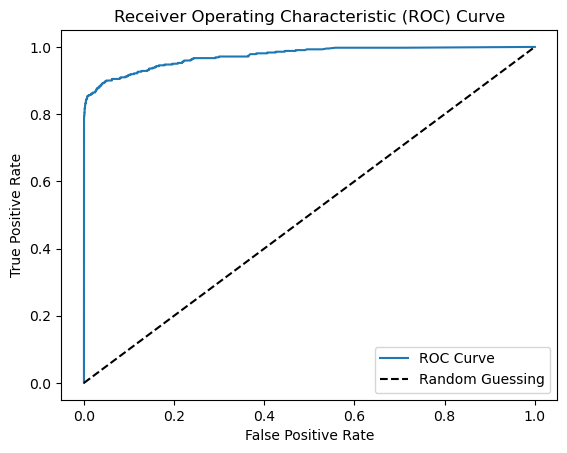

In [27]:
preds = xgb.predict_proba(X_val)
predicted_prob = [pred[1] for pred in preds]

fpr, tpr, thresholds = roc_curve(y_val, predicted_prob)

plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# # Calculate the confusion matrix
# predicted_labels = (predicted_prob >= 0.5).astype(int)  # Thresholding at 0.5
# confusion_mat = confusion_matrix(y_val, predicted_labels)

# print("Confusion Matrix:")
# print(confusion_mat)

In [28]:
# submission_df = pd.DataFrame({
# "id" : ids,
# "Machine failure": predicted_prob   
# })
# submission_df.shape

In [29]:
#submission_df.to_csv("submission8.csv", index=False)

In [30]:
# from catboost import CatBoostClassifier

# catboost = CatBoostClassifier(n_estimators=1000, learning_rate=0.01)
# catboost.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_val, y_val)], verbose=100)

# preds = catboost.predict_proba(test_X)
# predicted_prob = [pred[1] for pred in preds]
# print(predicted_prob[:5])

# print('Train score:', lgbm.score(X_train, y_train))
# print('Validation score:', lgbm.score(X_val, y_val))

In [31]:
# from sklearn.ensemble import RandomForestClassifier

# rf = RandomForestClassifier(n_estimators=1000)
# rf.fit(X_train, y_train)

# preds = rf.predict_proba(test_X)
# predicted_prob = [pred[1] for pred in preds]
# print(predicted_prob[:5])

# print('Train score:', lgbm.score(X_train, y_train))
# print('Validation score:', lgbm.score(X_val, y_val))

In [32]:
# from sklearn.ensemble import GradientBoostingClassifier

# gb = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01)
# gb.fit(X_train, y_train)

# preds = gb.predict_proba(test_X)
# predicted_prob = [pred[1] for pred in preds]
# print(predicted_prob[:5])

# print('Train score:', lgbm.score(X_train, y_train))
# print('Validation score:', lgbm.score(X_val, y_val))

In [33]:
# test_df = pd.read_csv("/kaggle/input/playground-series-s3e17/test.csv")
# test_df[categorical_cols] = encoder.transform(test_df[categorical_cols])
# test_df.columns = test_df.columns.str.replace('[\[\]]', '', regex=True)
# test_df["Power"] = test_df["Torque Nm"] * test_df["Rotational speed rpm"]
# test_df["temp_ratio"] = test_df["Process temperature K"] / test_df["Air temperature K"]

# ids = test_df["id"]
# test_X = test_df.drop(["id", "Product ID"], axis=1)